<a href="https://colab.research.google.com/github/TheLast20/Proteus_Librarie/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ya
Terminado


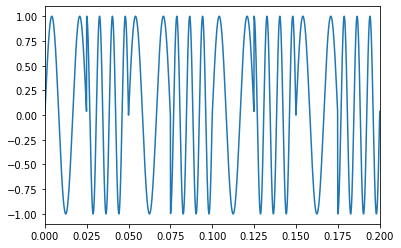

In [3]:
system = Signal(10,0.0001)
system.Generate_FM_Signal(amplitud=5,frecuency1=60,frecuency2=130,period=0.05)
system.Generate_Graph(min_x=0,max_x=0.2)
system.Generate_File("file")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Signal():
    def __init__(self,Tsim,Ts):
        #Simulation data
        self.Tsim = Tsim
        self.Ts = Ts

        #Create Array Time
        self.t =  np.arange(0,Tsim+Ts,Ts)
        self.t = self.t[:,np.newaxis]

        #Create Array Signal
        self.signal = np.zeros([self.t.shape[0],1])


        #Create necessary operation
        self.comparation = lambda x, min, max: np.logical_and(x > min, x < max)

    def Add_PWM(self,low_voltage,high_voltage,pulse_width,period=0,frecuency=0,start_time=0,end_time=0):

        #Initial data
        if period == 0 and frecuency != 0:
            period= 1 / frecuency

        if end_time == 0:
            end_time = float(max(self.t))

        #Separation
        space = period * (pulse_width / 100)

        self.auxiliar = np.zeros([self.t.shape[0], 1])

        num_period = round(end_time / period)


        for i in range(num_period):

            start = start_time + period * i
            stop = start_time + period * i + space
            if stop > end_time:
                stop = end_time
            self.auxiliar = np.logical_or(self.auxiliar, self.comparation(self.t, start, stop))

        self.auxiliar = self.auxiliar * 1

        self.auxiliar[self.auxiliar == 0] = low_voltage
        self.auxiliar[self.auxiliar == 1] = high_voltage

        # Eliminate DC gain
        self.aux = np.zeros([self.t.shape[0], 1])

        self.aux = np.logical_or(self.aux, self.comparation(self.t, -1, start_time))
        self.aux = np.logical_or(self.aux, self.comparation(self.t, end_time, float(max(self.t)) + 1))

        self.aux = low_voltage * self.aux
        self.auxiliar-= self.aux

        #Add a signal
        self.signal+= self.auxiliar

    def Add_Sinusoidal(self,Amplitud,Frecuency,DC_Gain=0,start_time=0,end_time=0,desfase=0,noise=0):
        if end_time == 0:
            end_time = float(max(self.t))



        self.sinusoidal = np.zeros([self.t.shape[0], 1])
        self.sinusoidal  = np.logical_or(self.sinusoidal , self.comparation(self.t, start_time, end_time))

        self.sinusoidal  = self.sinusoidal  * (Amplitud * np.sin(2 * np.pi * Frecuency * (self.t - start_time) + desfase * (np.pi / 180))) + DC_Gain

        # Eliminate DC gain
        self.aux1 = np.zeros([self.t.shape[0], 1])

        self.aux1 = np.logical_or(self.aux1, self.comparation(self.t, -1, start_time))
        self.aux1 = np.logical_or(self.aux1, self.comparation(self.t, end_time, float(max(self.t)) + 1))

        self.aux1 = DC_Gain * self.aux1

        self.sinusoidal -= self.aux1

        #Generate noise
        if noise!=0:
            self.aux2 = np.zeros([self.t.shape[0], 1])
            self.aux2 = np.logical_or(self.aux2,self.comparation(self.t,start_time,end_time))
            self.value_noise = (Amplitud*noise)*(2*np.random.rand(self.t.shape[0], 1)-1)
            self.aux2 = self.value_noise*self.aux2
            self.sinusoidal+=self.aux2


        self.signal+= self.sinusoidal

    def Generate_AM_Signal(self,amplitud,frecuency1,frecuency2,modulation=1):
        #Signal 1
        self.sinusoidal1 = np.sin(2 * np.pi * frecuency1 * (self.t ))

        #Signal 2
        self.A = modulation*(amplitud/2)
        self.time = self.t - ((amplitud*np.pi)/(4))*np.ones((self.t.shape[0],1))

        self.sinusoidal2 = self.A*np.sin(2*np.pi*frecuency2*self.time) + amplitud/2

        self.AM = self.sinusoidal1 * self.sinusoidal2

        self.signal+=self.AM


    def Generate_FM_Signal(self,amplitud,frecuency1,frecuency2,period,duty_cycle=50):
        self.n_cycles = round(self.Tsim/period)+1
        self.signal_aux = np.zeros((self.t.shape[0],1))
        for i in range(self.n_cycles):
            self.min = period * i
            self.max = period * i + period * (duty_cycle / 100)
            self.signal_aux = np.logical_or(self.signal_aux, self.comparation(self.t, self.min, self.max))

        self.signal += 1 * self.signal_aux * np.sin(2 * np.pi * frecuency1 * self.t)

        self.signal_aux = -1 * self.signal_aux
        self.signal_aux[self.signal_aux == 0] = 1
        self.signal_aux[self.signal_aux == -1] = 0
        self.signal += 1 * self.signal_aux * np.sin(2 * np.pi * frecuency2 * self.t)


    def Generate_File(self,name):
        archivo = open(name+".txt", "w")
        for i,dato in enumerate(self.t[:,0]):
            text = str(self.t[i,0])+" "+str(self.signal[i,0]) + "\r"
            archivo.write(text)
        archivo.close()

    def Generate_Graph(self,min_x = None, max_x = None, min_y = None, max_y = None):
        plt.plot(self.t,self.signal)
        if min_x != None and max_x != None:
            plt.xlim(min_x,max_x)

        elif min_x == None and max_x != None:
            plt.xlim(0,max_x)

        elif min_x != None and max_x == None:
            plt.xlim(min_x, max(self.t))

        if min_y != None and max_y != None:
            plt.ylim(min_y, max_y)

        elif min_y == None and max_y != None:
            plt.ylim(None, max_y)

        elif min_y != None and max_y == None:
            plt.ylim(min_y, None)

        plt.show()


